# Importing the Dependencies

In [1]:
#initialization
import numpy as np

#importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.quantum_info import Operator
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit.tools.jupyter import *
provider = IBMQ.load_account()

#import basic plot tools
from qiskit.visualization import plot_histogram

C:\Users\VIMAL\AppData\Local\Temp\ipykernel_18096\3145485948.py:10: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


# Grover's Algorithm

Grover's algorithm has three main components. 
1. First, we begin by creating a superposition of all $2^n$ computational basis states by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits. 
2. Second, we apply an Oracle operator to mark the appropriate elements among the $2^n$ elements. The oracle operator applies a coefficient of $-1$ to each of the marked elements.
3. Third, we apply a Diffusion operator, or diffuser, which inverts the amplitude of all elements about the average amplitude.

Putting these components together, and applying the Oracle and Diffusion operators $O(\sqrt{N = 2^n})$ times, Grover's algorithm allows us to successfully determine the elements that were marked by the Oracle operator with high probability. This is shown in the block diagram above, where the quantum circuit for Grover's algorithm is depicted with a measurement in the end to read out the qubits.

### Creating the Oracle

**Recall that the action of the phase oracle is to add a phase of $-1$ to all states representing the marked elements, while leaving all other states unchanged.** An easy way to implement the phase oracle is to create an identity matrix on all $n$ qubits (remember that the corresponding dimension of this matrix is $2^n$) and then change those diagonal elements to $-1$ that correspond to the marked elements. Then, you need to convert that unitary into an operator.

We have created a function below called `phase_oracle` which takes in two arguments. The first argument, $n$, gives the number of qubits in the quantum circuit. The second argument, `indices_to_mark`, is a list of the indices whose elements will be marked by the phase oracle with a phase of $-1$. Using these inputs, create a $2^n\times2^n$ identity matrix, and apply a phase of $-1$ to the diagonal elements at locations given in `indices_to_mark`. For example, if $0$ is in `indices_to_mark`, that means you need to set the top-left-most diagonal element of the identity matrix to -1.

Once you complete these steps, apply the unitary operator to the quantum circuit.

In [2]:
def phase_oracle(n, indices_to_mark, name = 'Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

### Creating the Diffuser

Next, we define the diffuser, which we call as $V$.  Its effect is to reflect all amplitudes about the average amplitude. To do so, we simply call the `phase_oracle` with only the zero state ($\vert0\rangle^{\otimes n}$) as the marked element and sandwich it between Hadamard gates applied to all qubits.

In [3]:
def diffuser(n):
    qc = QuantumCircuit(n, name='Diff - "V"')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]),range(n))
    qc.h(range(n))
    return qc

### Creating the main algorithm 

We need to determine the optimal number of rounds $r$ as described in the lecture.

This was given by 

$$r = \left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{k}}\right\rfloor$$

where $k$ is the number of marked elements, and $\lfloor~\rfloor$ means rounding down to the nearest integer.

Here we are appending the oracle and diffuser to this algorithm

In [4]:
def Grover(n, marked):
    qc = QuantumCircuit(n, n)
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state of {marked} marked, {r} rounds')
    qc.h(range(n))
    for _ in range(r):
        qc.append(phase_oracle(n, marked), range(n))
        qc.append(diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc

# Stimulating in local computer

 `Case 1:` When n = 5

5 qubits, basis state of [25] marked, 4 rounds


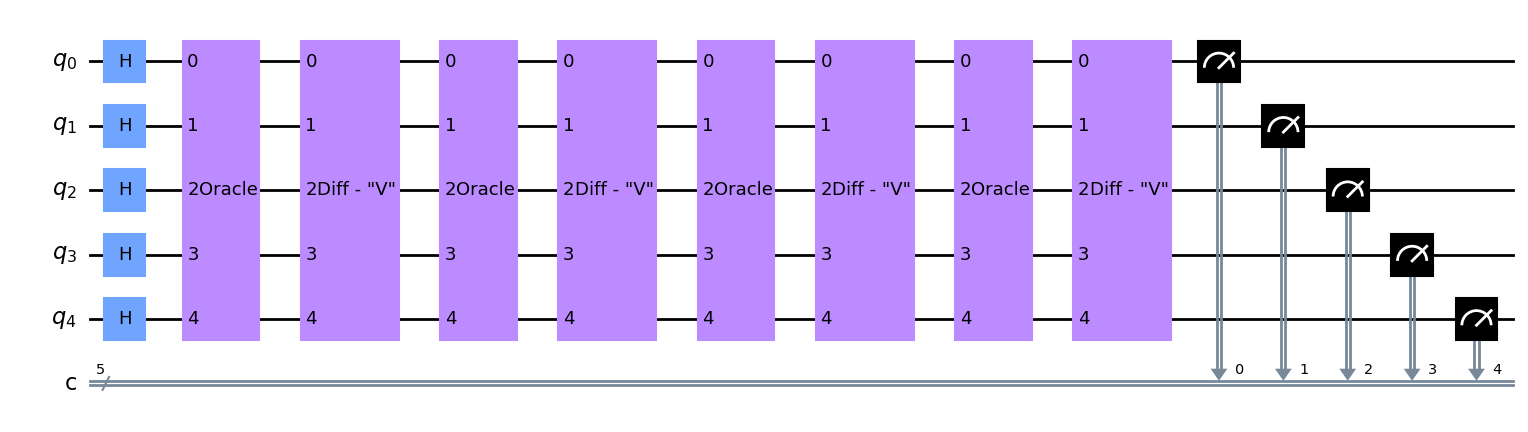

In [5]:
n = 5
x = np.random.randint(2**n)
marked = [x]
qc = Grover(n, marked)


qc.draw(output="mpl")

{'11001': 9991, '10110': 1, '00101': 1, '01010': 1, '10011': 1, '10100': 1, '01001': 2, '10101': 1, '00011': 1}
3.919534679768385


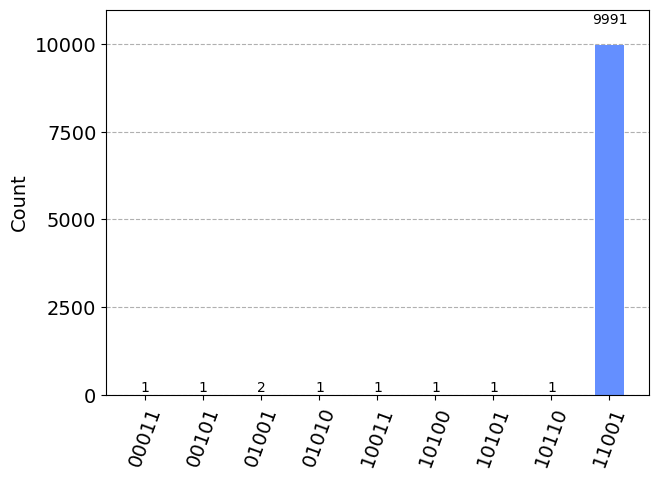

In [6]:
backend = BasicAer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=10000).result()
counts = result.get_counts(qc)
print(counts)
print(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)
plot_histogram(counts)

`Case 2:` When n = 6

6 qubits, basis state of [35] marked, 6 rounds


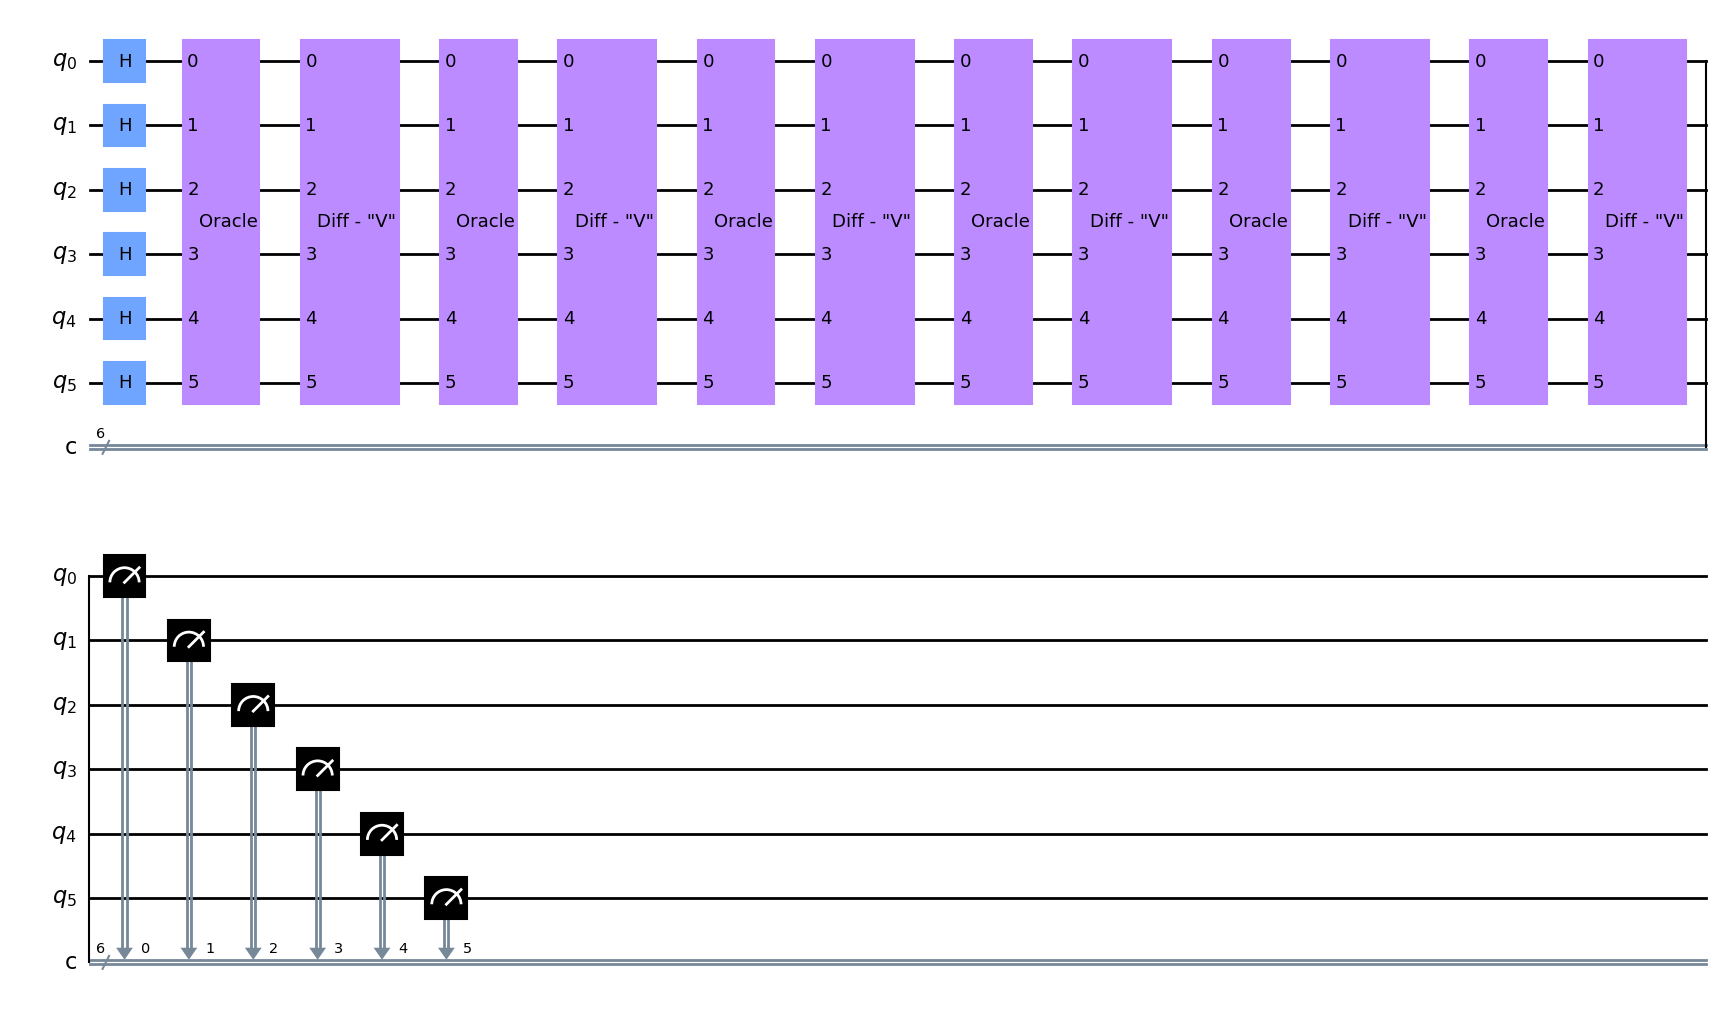

In [7]:
n = 6
x = np.random.randint(2**n)
marked = [x]
qc = Grover(n, marked)


qc.draw(output="mpl")

{'100011': 9969, '001011': 1, '010010': 1, '011011': 1, '101001': 1, '001000': 2, '100100': 1, '110001': 1, '001111': 2, '010000': 1, '111101': 1, '000000': 1, '000001': 2, '010110': 1, '100111': 1, '100001': 1, '101110': 1, '111011': 1, '011111': 1, '111001': 1, '101010': 1, '001010': 1, '010101': 1, '010001': 2, '111010': 2, '110011': 1, '000101': 1}
5.766749819872207


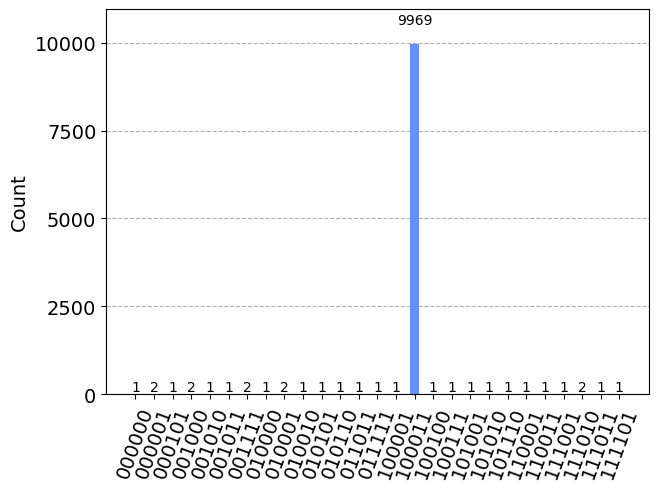

In [8]:
backend = BasicAer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=10000).result()
counts = result.get_counts(qc)
print(counts)
print(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)
plot_histogram(counts)

`Case 3:` When n = 3 and taking two marked bits

In [34]:
n = 3
x = np.random.randint(2**n)
y = np.random.randint(2**n)
while y==x:
    y = np.random.randint(2**n)
marked = [x,y]
qc = Grover(n, marked)

3 qubits, basis state of [3, 4] marked, 1 rounds


{'011': 4925, '100': 5075}
0.9999999999999998


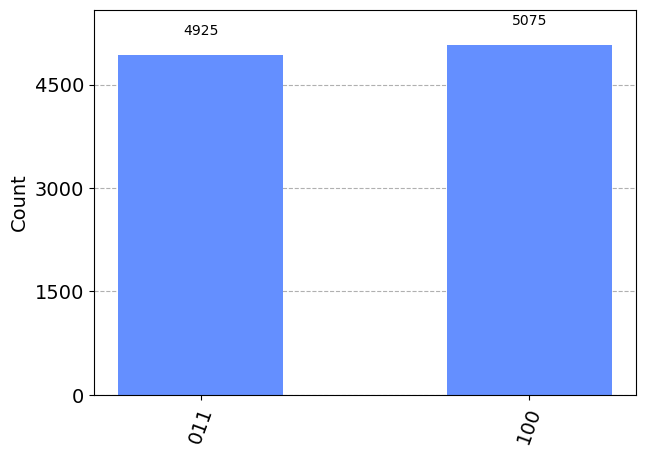

In [35]:
backend = BasicAer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=10000).result()
counts = result.get_counts(qc)
print(counts)
print(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)
plot_histogram(counts)

# Stimulating using Quantum Computer

`Case 1:` When n = 2

2 qubits, basis state of [2] marked, 1 rounds


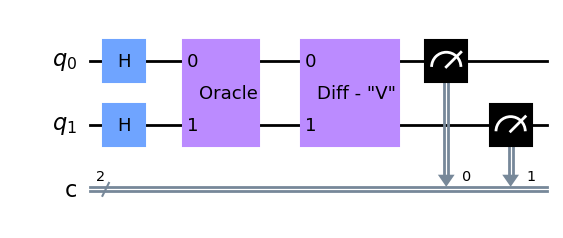

In [9]:
n_qc = 2
x = np.random.randint(2**n_qc)
marked = [x]
qc_qc = Grover(n_qc, marked)


qc_qc.draw(output="mpl")

In [10]:
backend_qc = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and 
                                         not x.configuration().simulator and x.status().operational==True))
print("Least busy backend: ", backend_qc)
%qiskit_job_watcher

shots = 1024
job = execute(qc_qc, backend=backend_qc, shots=shots, optimization_level=3)

Least busy backend:  ibmq_lima


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

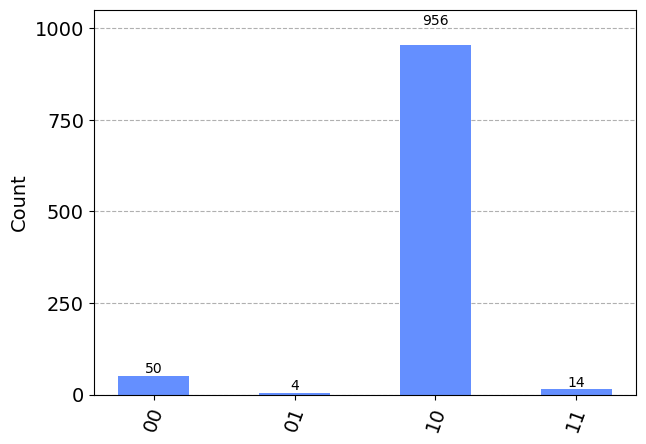

In [11]:
# Get the results of the computation
results_qc = job.result()
answer_qc = results_qc.get_counts()
plot_histogram(answer_qc)

Here we can see some errors

`Case 2 a):` When n = 3 and number of shots = 5000

In [20]:
n_qc = 3
x = np.random.randint(2**n_qc)
marked = [x]
qc_qc = Grover(n_qc, marked)

backend_qc = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and 
                                         not x.configuration().simulator and x.status().operational==True))
print("Least busy backend: ", backend_qc)
%qiskit_job_watcher

shots = 5000
job = execute(qc_qc, backend=backend_qc, shots=shots, optimization_level=3)

3 qubits, basis state of [7] marked, 2 rounds
Least busy backend:  ibmq_lima


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

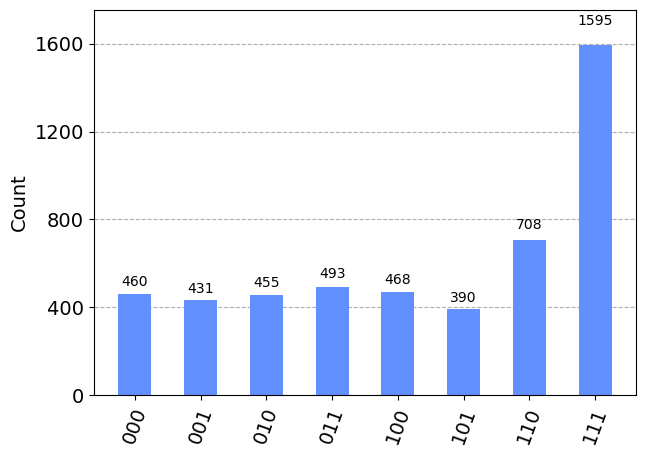

In [21]:
# Get the results of the computation
results_qc = job.result()
answer_qc = results_qc.get_counts()
plot_histogram(answer_qc)

As we can see, most of the results are 111. The other results are due to errors in the quantum computation.

`Case 2 b):` When n = 3 and number of shots = 10000

In [18]:
n_qc = 3
x = np.random.randint(2**n_qc)
marked = [x]
qc_qc = Grover(n_qc, marked)

backend_qc = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and 
                                         not x.configuration().simulator and x.status().operational==True))
print("Least busy backend: ", backend_qc)
%qiskit_job_watcher

shots = 10000
job = execute(qc_qc, backend=backend_qc, shots=shots, optimization_level=3)

3 qubits, basis state of [0] marked, 2 rounds
Least busy backend:  ibmq_lima


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

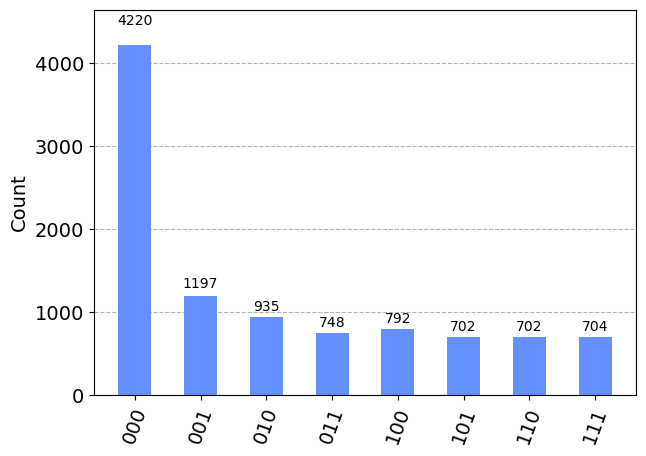

In [19]:
# Get the results of the computation
results_qc = job.result()
answer_qc = results_qc.get_counts()
plot_histogram(answer_qc)

As we can see, most of the results are 000. The other results are due to errors in the quantum computation. Here, we took 10000 shots to amplify the marked elements more than the average.

`Case 3:` When n = 3 and taking two marked bits and number of shots = 1024

In [9]:
n_qc = 3
x = np.random.randint(2**n_qc)
y = np.random.randint(2**n_qc)
while y==x:
    y = np.random.randint(2**n_qc)
marked = [x,y]
qc_qc = Grover(n_qc, marked)

backend_qc = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and 
                                         not x.configuration().simulator and x.status().operational==True))
print("Least busy backend: ", backend_qc)
%qiskit_job_watcher

shots = 1024
job = execute(qc_qc, backend=backend_qc, shots=shots, optimization_level=3)

3 qubits, basis state of [0, 6] marked, 1 rounds
Least busy backend:  ibmq_lima


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

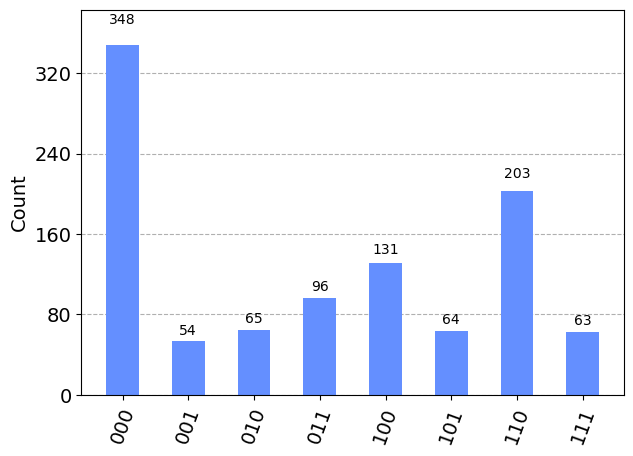

In [10]:
# Get the results of the computation
results_qc = job.result()
answer_qc = results_qc.get_counts()
plot_histogram(answer_qc)

As we can see, most of the results are in binary 000 and 110 in digits 0 and 6 respectively. The other results are due to errors in the quantum computation. Here, we took 1024 shots.

`Case 4:` When n = 3 and taking two marked bits, number of shots = 5000

In [28]:
n_qc = 3
x = np.random.randint(2**n_qc)
y = np.random.randint(2**n_qc)
while y==x:
    y = np.random.randint(2**n_qc)
marked = [x,y]
qc_qc = Grover(n_qc, marked)

backend_qc = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and 
                                         not x.configuration().simulator and x.status().operational==True))
print("Least busy backend: ", backend_qc)
%qiskit_job_watcher

shots = 5000
job = execute(qc_qc, backend=backend_qc, shots=shots, optimization_level=3)

3 qubits, basis state of [6, 4] marked, 1 rounds
Least busy backend:  ibmq_lima


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

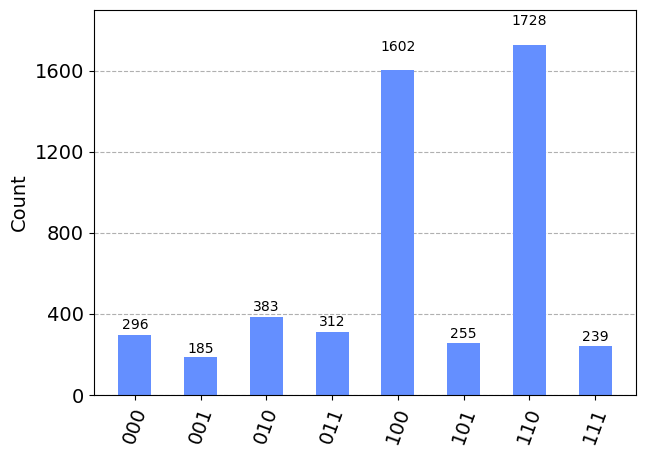

In [29]:
# Get the results of the computation
results_qc = job.result()
answer_qc = results_qc.get_counts()
plot_histogram(answer_qc)

As we can see, most of the results are in binary 100 and 110 in digits as 4 and 6 respectively. The other results are due to errors in the quantum computation. Here, we took 5000 shots to amplify the marked elements more than the average and strinks other elements.